# Model simulation with reestimated parameters 

## Batch model   

In [56]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
import pandas as pd
import functools


from scipy.optimize import differential_evolution as diff_evol

class SpecialDict(dict):
    
    def values(self):
        return list(super().values())
    
% run functions.ipynb

matplotlib.rc('xtick', labelsize=15)     
matplotlib.rc('ytick', labelsize=15)

#### Model with calculated parameters in the model

In [57]:
batch_model = '''
model *IDModel()

    ######## Set the compartment to 1
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1;

    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 5.6049 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4291 # (g/(g*h))
    
    mu_max = 0.2477 # [1/h]
    Ks = 1.27 # [g/L]
    Ks_qs = 5.26 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4291 # (g/(g*h))
    
    a = 0.0141
    b = 1.1369
    c = 202.56

    ######## Initial conditions
    V := (a*time^2 - b*time + c)/1000 # [L]
    glucose_init = 0.094696 # [g]
    glucose = glucose_init # [g]
    biomass_init = 0.020588 # [g]
    biomass = biomass_init # [g]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]

    ######## Functions
    mu := mu_max*c_glucose/(c_glucose+Ks+(c_glucose^2/Ki)) # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g/g h] 
    
    ######## Mass Balances 
    eq_glucose: -> glucose; -qs*biomass # [g/h]
    eq_biomass: -> biomass; mu*biomass # [g/h]
    
    end
'''

#### Load experimental data 

In [58]:
R1_amounts = pd.read_csv('estimation/batch_amounts/R1_amounts.csv', index_col=0)
R2_amounts = pd.read_csv('estimation/batch_amounts/R2_amounts.csv', index_col=0)
R3_amounts = pd.read_csv('estimation/batch_amounts/R3_amounts.csv', index_col=0)
R4_amounts = pd.read_csv('estimation/batch_amounts/R4_amounts.csv', index_col=0)
R5_amounts = pd.read_csv('estimation/batch_amounts/R5_amounts.csv', index_col=0)
R6_amounts = pd.read_csv('estimation/batch_amounts/R6_amounts.csv', index_col=0)
R7_amounts = pd.read_csv('estimation/batch_amounts/R7_amounts.csv', index_col=0)
R8_amounts = pd.read_csv('estimation/batch_amounts/R8_amounts.csv', index_col=0)
R9_amounts = pd.read_csv('estimation/batch_amounts/R9_amounts.csv', index_col=0)
R10_amounts = pd.read_csv('estimation/batch_amounts/R10_amounts.csv', index_col=0)
R11_amounts = pd.read_csv('estimation/batch_amounts/R11_amounts.csv', index_col=0)
R12_amounts = pd.read_csv('estimation/batch_amounts/R12_amounts.csv', index_col=0)

#### Plot of data and model

In [59]:
# This is a function that simulates the model for an experiment, so the volume parameters a,b and c can be setted in the model as well as the initial conditions

def simulate(R_amounts):
    
    ''' Simulates the model with certain initial values
    
    Args: 
        R: Data frame with the analytical data in amounts, which should contain a column for initial value parameter a, b, c, glucose and biomass. 
        
    Returns:
        r_results: Model output'''
    
    r = te.loada(batch_model)
    r.a = R_amounts['a'][0]
    r.b = R_amounts['b'][0]
    r.c = R_amounts['c'][0]
    r.glucose_init = R_amounts['Glucose initial (g)'][0]
    r.biomass_init = R_amounts['Biomass initial (g)'][0]

    r.reset()
    #r.exportToSBML('filename.xml') if one wants to save model as SBML
    r.timeCourseSelections = ['time','glucose','biomass','mu','V','qs']
    
    r_results = r.simulate(1.7, 22.5, 100)
    
    return r_results

In [60]:
# For each experiment the function simulate is being run

batch_data = R1_amounts, R2_amounts, R3_amounts, R4_amounts, R5_amounts, R6_amounts, R7_amounts, R8_amounts, R9_amounts, R10_amounts, R11_amounts, R12_amounts
simulated_batch_data = list(map(simulate, batch_data))

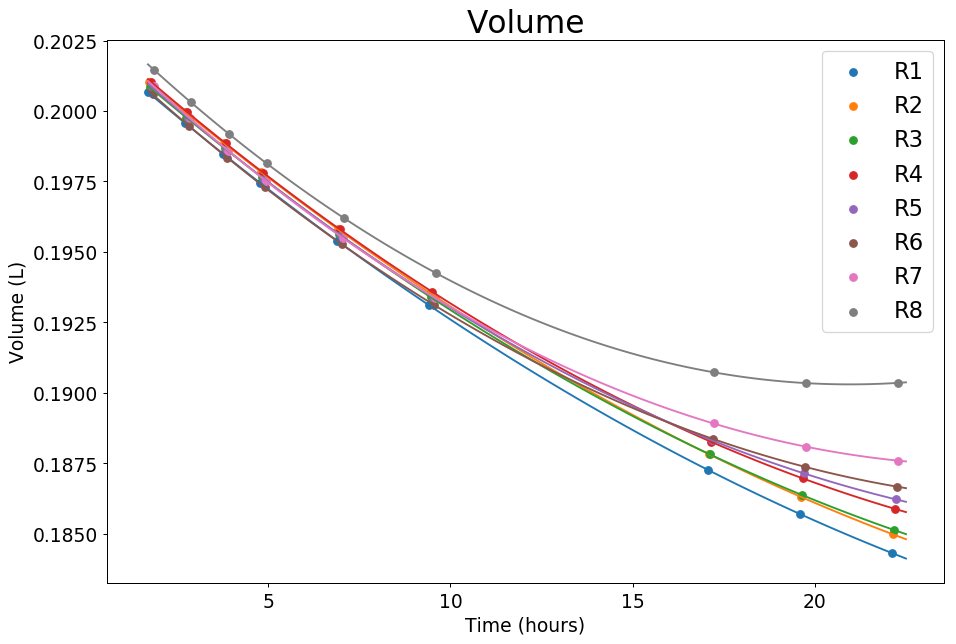

In [61]:
plt.figure(num=None, figsize=(12, 8), dpi=90, facecolor='w', edgecolor='k')
for i in range(len(simulated_batch_data[:8])):
    
    plt.plot(simulated_batch_data[:8][i][:, 0], simulated_batch_data[:8][i][:, 4])
    plt.scatter(batch_data[:8][i]['Time (hours)'], batch_data[:8][i]['Volume (L)'], label = 'R' + str(i+1))
    plt.xlabel('Time (hours)', fontsize = 15)
    plt.ylabel('Volume (L)', fontsize = 15)
    plt.title('Volume', fontsize = 25)
plt.legend(fontsize = 18)
plt.savefig('figures/modeloutput/batch/estpar_volume.pdf')
plt.show()

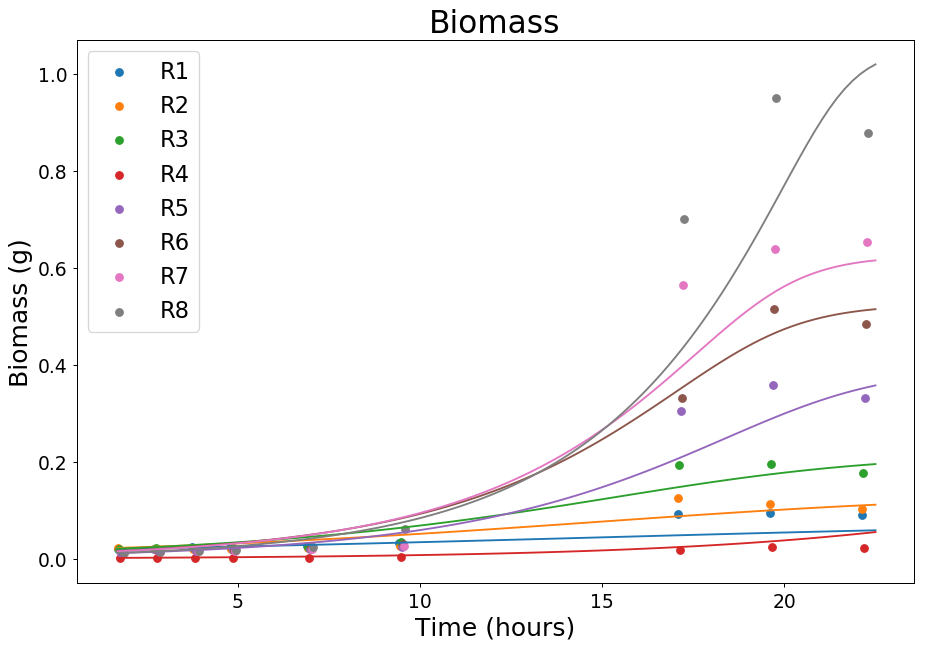

In [62]:
plt.figure(num=None, figsize=(12, 8), dpi=90, facecolor='w', edgecolor='k')
for i in range(len(simulated_batch_data[:8])):

    plt.plot(pd.DataFrame(simulated_batch_data[:8][i][:, 0]), (pd.DataFrame(simulated_batch_data[:8][i][:, 2])))
    plt.scatter(batch_data[:8][i]['Time (hours)'], batch_data[:8][i]['Biomass (g)'],label = 'R' + str(i+1))
    plt.legend(['Biomass from model', 'Biomass from data'], loc='upper left')
    plt.xlabel('Time (hours)', fontsize = 20)
    plt.ylabel('Biomass (g)', fontsize = 20)
    plt.title('Biomass', fontsize = 25)

plt.legend(fontsize = 18)
plt.savefig('figures/modeloutput/batch/estpar_biomass.pdf')
plt.show()

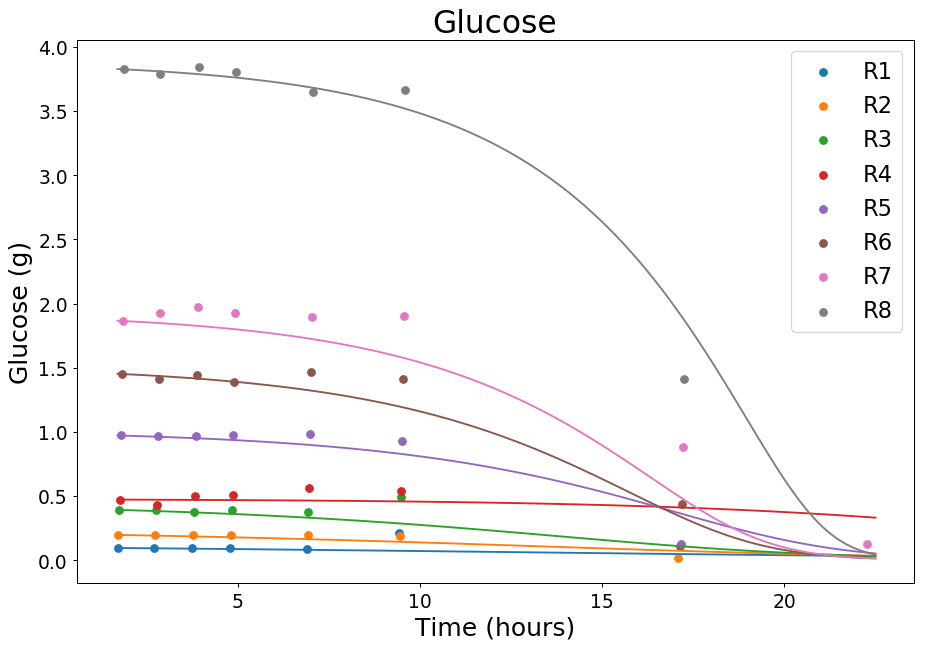

In [63]:
plt.figure(num=None, figsize=(12, 8), dpi=90, facecolor='w', edgecolor='k')
for i in range(len(simulated_batch_data[:8])):

    plt.plot(simulated_batch_data[:8][i][:, 0], simulated_batch_data[:8][i][:, 1])
    plt.scatter(batch_data[:8][i]['Time (hours)'], batch_data[:8][i]['Glucose (g)'], label = 'R' + str(i+1))
    plt.legend(['Glucose from model', 'Glucose from data'], loc='upper right')
    plt.xlabel('Time (hours)', fontsize = 20)
    plt.ylabel('Glucose (g)', fontsize = 20)
    plt.title('Glucose', fontsize = 25)
    
plt.legend(fontsize = 18)
plt.savefig('figures/modeloutput/batch/estpar_glucose.pdf')
plt.show()   

## Fed batch model 

In [5]:
R23_amounts = pd.read_csv('estimation/fedbatch_amounts/R23_amounts.csv', index_col=0)
R24_amounts = pd.read_csv('estimation/fedbatch_amounts/R24_amounts.csv', index_col=0)
R23_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R23.csv')
R24_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R24.csv')
R23_CO2_selected, mu_R23 = calculate_mu_fedbatch(R23_CO2, 23)
R24_CO2_selected, mu_R24 = calculate_mu_fedbatch(R24_CO2, 24)

In [51]:
fedbatch_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 5.6049 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4291 # (g/(g*h))
    F0 = 0.3
    mu_set = 0.02
    alpha = 5
    beta = 0.5

    ######## Initial conditions
    V = 0.1021
    glucose = 0 # 0.149770*V # [g]
    biomass = 0.209504 #5.092*V # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := F0*exp(mu_set*time)/1000 # [L/h]
    
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V


    ######## Functions
    mu := mu_max*c_glucose/(c_glucose+Ks+(c_glucose^2/Ki)) # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta)
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed -0.002 # [g/h]  
    eq_serine: -> serine; qp*biomass # [g/h]
    

    end
'''

r = te.loada(fedbatch_model)
    
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V']
results = r.simulate(12.5, 33, 100)

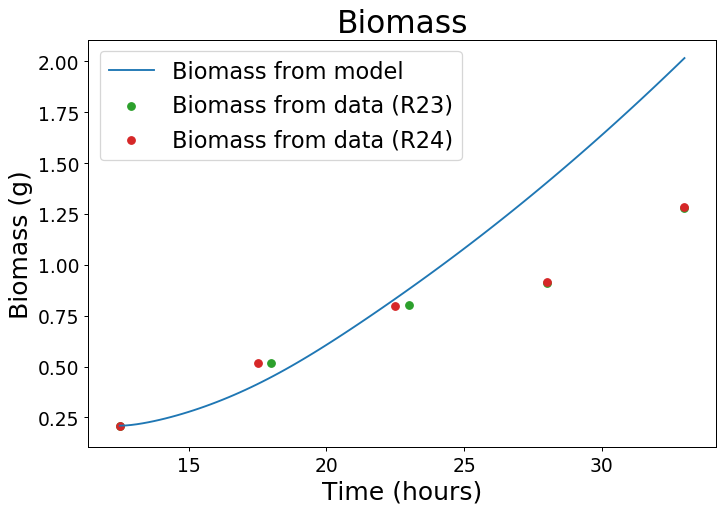

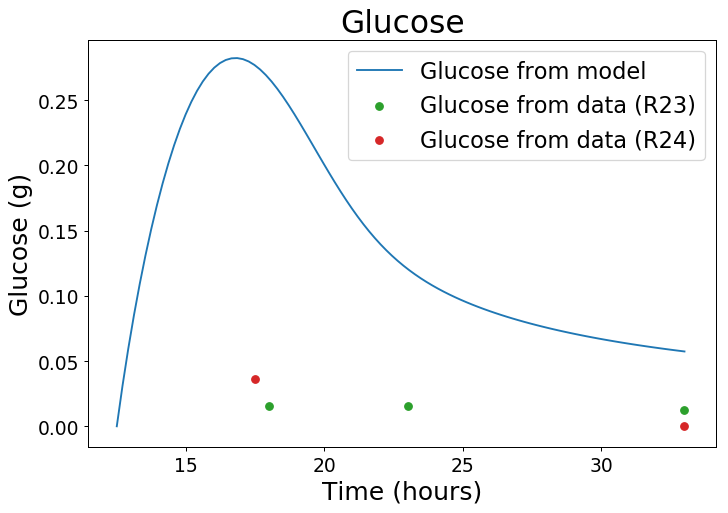

In [52]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 2])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5], color = 'C3')
plt.legend(['Biomass from model', 'Biomass from data (R23)', 'Biomass from data (R24)'], loc='upper left', fontsize = 18)
plt.xlabel('Time (hours)', fontsize = 20)
plt.ylabel('Biomass (g)', fontsize = 20)
plt.title('Biomass', fontsize = 25)
plt.savefig('figures/modeloutput/fedbatch/estparbatch_biomass.pdf')

plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 1])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5], color = 'C3')
plt.legend(['Glucose from model', 'Glucose from data (R23)', 'Glucose from data (R24)'], loc='upper right', fontsize = 18)
plt.xlabel('Time (hours)', fontsize = 20)
plt.ylabel('Glucose (g)', fontsize = 20)
plt.title('Glucose', fontsize = 25)
plt.savefig('figures/modeloutput/fedbatch/estparbatch_glucose.pdf')


plt.show()

## Fed batch model with batch phase

In [54]:
mu_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 2.6784 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4075 # (g/(g*h))
    F0 = 0.3
    mu_set = 0.02
    alpha = 1.5007
    beta = 2.7714
    switch = 0
    IPTG = 0

    ######## Initial conditions
    V = 0.1021
    glucose = 10*V #0 # 0.149770*V # [g]
    biomass_init = 0.15 # [g/L]
    biomass = biomass_init*V  # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := switch*F0*exp(mu_set*time)/1000 # [L/h]
    
    ######## If fed batch
    at (time > 12.5): switch = 1, IPTG = 1
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V


    ######## Functions
    mu := mu_max*c_glucose/(c_glucose+Ks+(c_glucose^2/Ki)) # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta)#*IPTG
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed # [g/h]  
    eq_serine: -> serine; qp*biomass*IPTG # [g/h]
    
    yield := serine/glucose
    qpbio := qp*biomass
    

    end
'''

r = te.loada(mu_model)

r.exportToSBML('estimation/model_fedbatch_batchphase.xml')
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V','qs','qp','yield','qpbio']
results = r.simulate(0, 33, 67)
#results

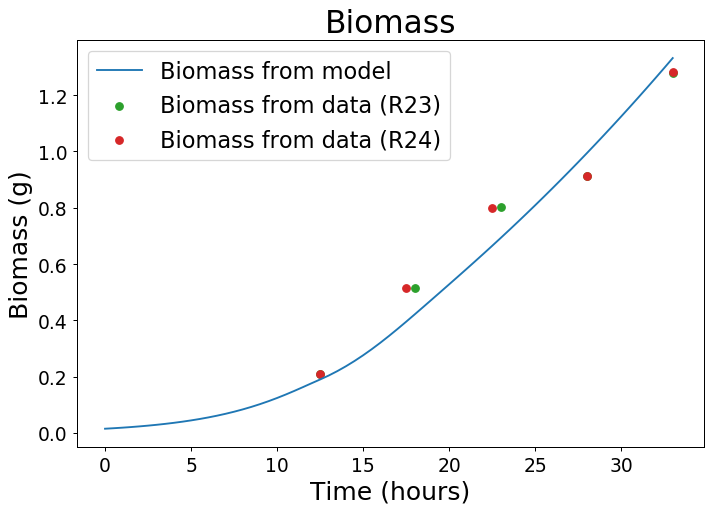

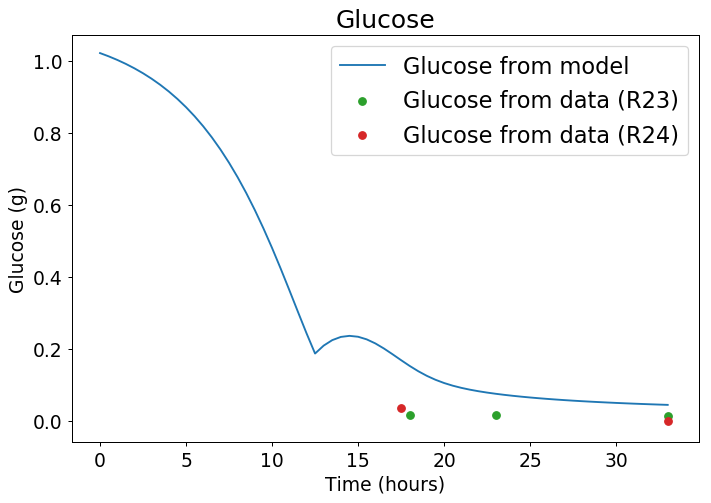

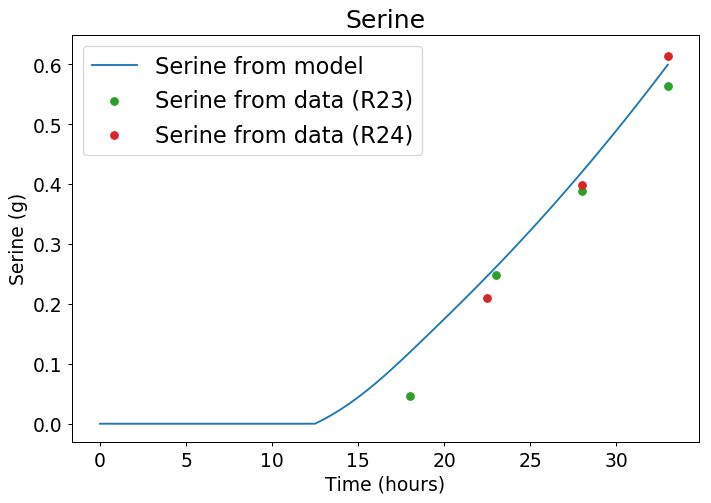

In [55]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 2])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5], color = 'C3')
plt.legend(['Biomass from model', 'Biomass from data (R23)', 'Biomass from data (R24)'], loc='upper left', fontsize = 18)
plt.xlabel('Time (hours)', fontsize = 20)
plt.ylabel('Biomass (g)', fontsize = 20)
plt.title('Biomass', fontsize = 25)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_biomass.pdf')

plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 1])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5], color = 'C3')
plt.legend(['Glucose from model', 'Glucose from data (R23)', 'Glucose from data (R24)'], loc='upper right', fontsize = 18)
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Glucose (g)', fontsize = 15)
plt.title('Glucose', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_glucose.pdf')


plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 3])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5], color = 'C3')
plt.legend(['Serine from model', 'Serine from data (R23)', 'Serine from data (R24)'], loc='upper left', fontsize = 18)
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Serine (g)', fontsize = 15)
plt.title('Serine', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_serine.pdf')


plt.show()


##### Following is for the volume and flow rate 
#plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

#plt.plot(results[:, 0], results[:, 5])
#plt.scatter(R23_CO2_selected['Time'][:67], R23_CO2_selected['Bioreactor 23 - Feed#1 flow rate'][:67]/1000, color = 'C2')
#plt.scatter(R23_CO2_selected['Time'][:67], R23_CO2_selected['Bioreactor 24 - Volume'][:67], color = 'C3')
#plt.xlabel('Time (hours)', fontsize = 15)
#plt.ylabel('Feed flow rate', fontsize = 15)

#plt.show()

#plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

#plt.plot(results[:, 0], results[:, 6])
#plt.scatter(R23_CO2_selected['Time'][:67], R23_CO2_selected['Bioreactor 23 - Volume'][:67]/1000, color = 'C2')
#plt.scatter(R23_CO2_selected['Time'][:67], R23_CO2_selected['Bioreactor 24 - Volume'][:67], color = 'C3')
#plt.xlabel('Time (hours)', fontsize = 15)
#plt.ylabel('Volume', fontsize = 15)

#plt.scatter([12.6, 17.6, 22.6, 27.6, 32.6],[0.1, 0.1, 0.1, 0.1, 0.1])


#plt.show()